# WT partial differential equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the KdV equation. 

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import colorcet as cc
import pandas as pd

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.analysis import load_tensorboard

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

Data_File_Name      : str   = "Tr_G_WT_normalized_focused";
Noise_Proportion    : float = 0.1;

average_window = 5;
average_min_periods = 1;
rolling_average_type = 'gaussian';
sigma_space = 4;
nb_x_points = 252;
nb_t_points = 242;
time_born_change : bool = True;
time_frame_start : int = 30;
time_frame_end : int = 128;

normalize_signal : bool = False;

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
#device = "cpu"

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def signal_space_derivative(signal_matrix : pd.DataFrame(),
                            nb_nx_points : int,average_window : int,
                            average_min_periods :int,
                            sigma_space :int,
                            rolling_average_type : str = 'gaussian'):
    signal_matrix_dx = signal_matrix.copy()
    nx_dx = signal_matrix_dx['nx'].iloc[:-1]
    signal_matrix_dx = signal_matrix_dx.diff()
    signal_matrix_dx['nx_delta'] = signal_matrix_dx['nx']*0.5
    for column in signal_matrix_dx.columns:
        signal_matrix_dx.loc[:,column] = signal_matrix_dx.loc[:,column]/signal_matrix_dx.loc[:,'nx']
    signal_matrix_dx.dropna(inplace=True)
    signal_matrix_dx.reset_index(drop=True, inplace=True)
    signal_matrix_dx['nx'] = nx_dx + signal_matrix_dx['nx_delta']
    signal_matrix_dx.drop(['nx_delta'], axis=1, inplace=True)
    min_nx_dx = signal_matrix_dx['nx'].min()
    max_nx_dx = signal_matrix_dx['nx'].max()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_dx_averaged = pd.DataFrame()
    signal_matrix_dx_averaged['nx'] = nx_dx_linearized
    signal_matrix_dx_averaged_temporal = signal_matrix_dx.copy()
    signal_matrix_dx_averaged_temporal.drop(['nx'], axis=1, inplace=True)
    for column in signal_matrix_dx_averaged_temporal.columns:
        ny = np.interp(nx_dx_linearized,signal_matrix_dx['nx'],signal_matrix_dx_averaged_temporal[column])
        signal_matrix_dx_averaged[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged

def signal_time_derivative(signal_matrix : pd.DataFrame(),
                           nb_dt_points : int,
                           average_window : int,
                           average_min_periods : int,
                           sigma_time : int,
                           rolling_average_type : str = 'gaussian'):
    # time derivative
    signal_matrix_dt = signal_matrix.copy()
    nt_dt = signal_matrix_dt['nt'].iloc[:-1]
    nt_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt = signal_matrix_dt.diff()
    signal_matrix_dt['nt_delta'] = signal_matrix_dt['nt'] * 0.5
    for column in signal_matrix_dt.columns:
        signal_matrix_dt.loc[:,column] = signal_matrix_dt.loc[:,column]/signal_matrix_dt.loc[:,'nt']
    signal_matrix_dt.dropna(inplace=True)
    signal_matrix_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt['nt'] = nt_dt + signal_matrix_dt['nt_delta']
    signal_matrix_dt.drop(['nt_delta'], axis=1, inplace=True)
    min_nt_dt = signal_matrix_dt['nt'].min()
    max_nt_dt = signal_matrix_dt['nt'].max()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_dt_points)
    signal_matrix_dt_averaged = pd.DataFrame()
    signal_matrix_dt_averaged_temporal = signal_matrix_dt.copy()
    signal_matrix_dt_averaged_temporal.drop(['nt'], axis=1, inplace=True)
    signal_matrix_dt_averaged['nt'] = nt_dt_linearized
    for column in signal_matrix_dt_averaged_temporal.columns:
        ny = np.interp(nt_dt_linearized,signal_matrix_dt['nt'],signal_matrix_dt_averaged_temporal[column])
        signal_matrix_dt_averaged[column] = ny
        signal_matrix_dt_averaged[column] = signal_matrix_dt_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_time)
    signal_matrix_dt_averaged['nt'] = signal_matrix_dt_averaged.loc[:,'nt'].rolling(window = average_window,
                                                                                    min_periods = average_min_periods,
                                                                                    center=True).mean()
    signal_matrix_dt_averaged = signal_x_common_base(signal_matrix_dt_averaged,'nt',
                                                     signal_matrix_dt_averaged['nt'].min(),
                                                     signal_matrix_dt_averaged['nt'].max(),
                                                     nb_dt_points)
    return signal_matrix_dt_averaged

def signal_x_common_base(signal_matrix_space : pd.DataFrame(), ref_coordinates_column : str, min_nx_dx : float, max_nx_dx : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_space.copy()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nx_dx_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nx_dx_linearized, signal_matrix_space[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def signal_t_common_base(signal_matrix_time : pd.DataFrame(), ref_coordinates_column : str, min_nt_dt : float, max_nt_dt : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_time.copy()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_nt_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nt_dt_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nt_dt_linearized, signal_matrix_time[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def plot_signal_space_derivative_fixed_time(signal_matrix_space : pd.DataFrame(),ref_time_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_frame: int, end_frame : int, delta_t : int, chi_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
    for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
            frame = 't' + str(time_frame)
            signal = signal_matrix_space.loc[:,signal_matrix_space.columns.str.endswith(frame) | signal_matrix_space.columns.str.contains('nx')].copy()
            signal = signal[(signal['nx']>chi_threshold)]
            plt.plot(signal['nx'], signal[quantity+'_r_avrg_'+ frame],c=color,label = ref_time_label_df.iloc[time_frame]['time_label']+' APF')
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

def plot_signal_time_derivative_fixed_space(signal_matrix_time : pd.DataFrame(),ref_space_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_chi_column: int, end_chi_column : int, delta_chi : int, t_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_chi_column  - start_chi_column + 1) / delta_chi)))
    for chi_column,color in zip(range(start_frame,end_frame ,delta_t),colors):
        signal = signal_matrix_time[(signal_matrix_time['nt']>t_threshold)]
        plt.plot(signal.loc[:,'nt'], signal.loc[:,chi_column],c=color,label = r'%s $\mu$' %str(np.round(ref_space_label_df.loc[chi_column,'nx'],decimals = 1)))
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$t(hAPF)$', ylabel = r'$ %s \equiv F(t|\chi)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()
    
def signal_rebase(matrix : pd.DataFrame(), x_ref : np.array(()), t_ref : np.array(()), nb_x : int, nb_t : int, average_window_characteristics):
    average_window = average_window_characteristics[0];
    average_min_periods = 1;
    rolling_average_type = 'gaussian';
    sigma_space = average_window_characteristics[3];
    matrix_interpolated_temporal = matrix.copy();
    matrix_interpolated_temporal.reset_index(drop=True, inplace=True);
    x_min = x_ref.min();
    x_max = x_ref.max();
    print('x_min:',x_min);
    print('x_max:',x_max);
    t_min = t_ref.min();
    t_max = t_ref.max();
    print('t_min:',x_min);
    print('t_max:',x_max);
    x_new = np.linspace(x_min, x_max, nb_x);
    t_new = np.linspace(t_min, t_max, nb_t);
    matrix_temporal = [];
    for column in range(matrix_interpolated_temporal.columns.size):
        ny = np.interp(x_new, x_ref, matrix_interpolated_temporal[column]);
        matrix_temporal.append(ny);
    matrix_temporal_df = pd.DataFrame(matrix_temporal);
    matrix_temporal_df.rolling(window = average_window,
                               min_periods = average_min_periods,
                               win_type = rolling_average_type).mean(std = sigma_space);
    matrix_temporal = [];
    for column in range(matrix_temporal_df.columns.size):
        ny = np.interp(t_new, t_ref, matrix_temporal_df[column]);
        matrix_temporal.append(ny);
    matrix_new = pd.DataFrame(matrix_temporal);
    matrix_new.rolling(window = average_window,
                       min_periods = average_min_periods,
                       win_type = rolling_average_type).mean(std = sigma_space);
    return x_new, t_new, matrix_new    

cpu


Before we send the data into the Dataset format, create a plot to get an idea of the data:

Shape of grid space_coordinate: (140,)
time borns will change !
Shape of grid u_data: (140, 98)
Shape of grid time_coordinate: (98,)
x_min: 0.0
x_max: 74.82000030283623
t_min: 0.0
t_max: 74.82000030283623
Shape of grid u_data resized: (252, 242)
Shape of grid t: (252, 242)
Shape of grid x: (252, 242)
Shape of grid u: (252, 242)


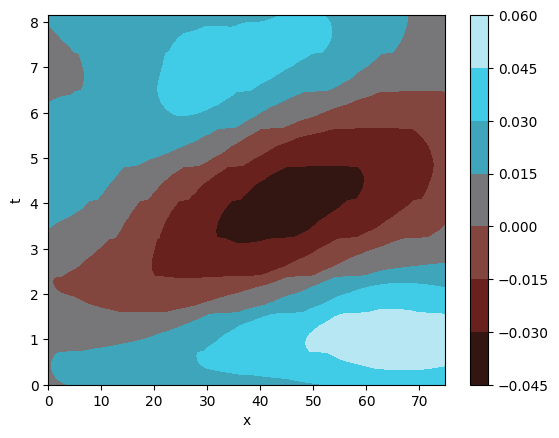

In [2]:
# Load data file.
Data_Set_Signal_Path  = 'dataset/signal_matrix_space_data.csv';
Data_Set_Time_Path  = "dataset/plot_time_label_df.csv";
time_data = pd.read_csv(Data_Set_Time_Path);
signal_data = pd.read_csv(Data_Set_Signal_Path)
space_coordinate = np.squeeze(signal_data['nx'].values);
print('Shape of grid space_coordinate:', space_coordinate.shape);
time_coordinate = time_data['frame_in_hours'].values;
u_data = signal_data.copy();
u_data = u_data.drop(columns=['nx']);
if time_born_change:
    print('time borns will change !')
    time_coordinate = time_coordinate[time_frame_start:time_frame_end];
    u_data = u_data.iloc[:,time_frame_start:time_frame_end].copy();
    print('Shape of grid u_data:', u_data.shape);
time_coordinate_offset = time_coordinate.min();
time_coordinate = time_coordinate - time_coordinate_offset;
space_coordinate_offset = space_coordinate.min();
space_coordinate = space_coordinate - space_coordinate_offset;
print('Shape of grid time_coordinate:', time_coordinate.shape);
#resize the input data to 'nb_x_points'x'nb_t_points'
average_window_characteristics = [average_window, 
                                  average_min_periods,
                                  rolling_average_type,
                                  sigma_space];
u_data_copy = u_data.copy();
u_data_copy.columns = range(u_data_copy.shape[1]);
u_data_copy.reset_index(drop=True, inplace=True);

x_new, t_new, u_new = signal_rebase(u_data_copy,
                                    space_coordinate,
                                    time_coordinate,
                                    nb_x_points,
                                    nb_t_points,
                                    average_window_characteristics);
if normalize_signal:
    u_new_min = u_new.min().min();
    u_new_max = u_new.max().max();
    u_new_normalized = (u_new - u_new_min)/(u_new_max - u_new_min)*2-1;
    u_new = u_new_normalized;
    
t,x = np.meshgrid(t_new,x_new);
print('Shape of grid u_data resized:',  u_new.shape);
data_in = {};
data_in['t'] = t;
print('Shape of grid t:', data_in['t'].shape);
data_in['x'] = x;
print('Shape of grid x:', data_in['x'].shape);
data_in['u'] = u_new;
print('Shape of grid u:', data_in['u'].shape);


fig, ax = plt.subplots()
im = ax.contourf(data_in['x'], data_in['t'],data_in['u'], cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()

We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [4]:
def load_data():
    coords = torch.from_numpy(np.stack((data_in['t'].tolist(),data_in['x'].tolist()), axis=-1)).float()
    data = torch.from_numpy(np.real(data_in['u'].to_numpy())).unsqueeze(-1).float()
    return coords, data

In [5]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 25000},
    device=device,
)

Dataset is using device:  cuda


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [6]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [7]:
network = NN(2, [60, 60, 60, 60], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [8]:
library = Library1D(poly_order=2, diff_order=2) 

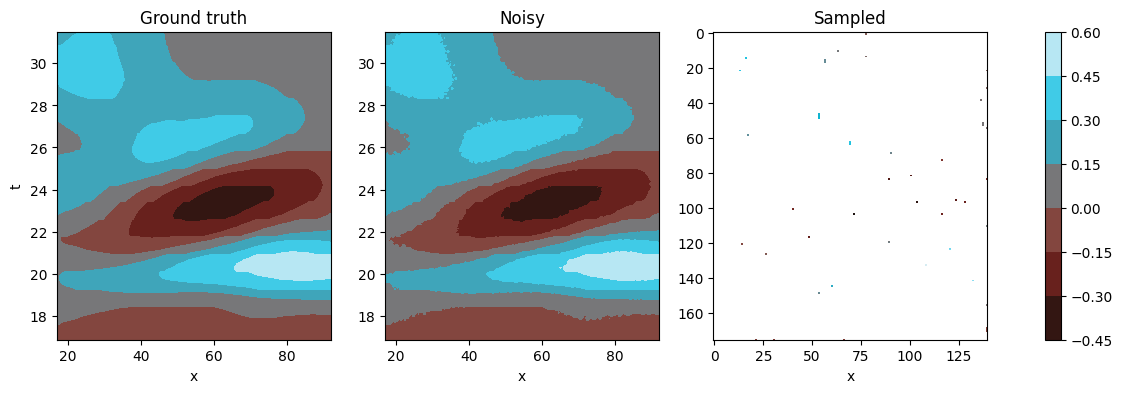

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged. 

In [9]:
estimator = Threshold(0.1)
#estimator = PDEFIND()
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5)

Configuration of the sparsity estimator

In [10]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [11]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:

- The directory where the tensorboard file is written (log_dir)
- The ratio of train/test set used (split)
- The maximum number of iterations performed (max_iterations)
- The absolute change in L1 norm considered converged (delta)
- The amount of epochs over which the absolute change in L1 norm is calculated (patience)



In [13]:
train(model, train_dataloader, test_dataloader, optimizer, sparsity_scheduler, log_dir='runs/test_008/', split=0.8, max_iterations=100000)

  2975  MSE: 3.43e-05  Reg: 7.72e-06  L1: 2.13e+00 Algorithm converged. Writing model to disk.


In [14]:
model_sparsity_masks = model.sparsity_masks

In [15]:
model_estimator_coeffs = model.estimator_coeffs()

There's two groups: the model.estimator_coeffs() are the coefficients as returned by the sparsity estimator, and are always normalized. The model.constraint_coeffs() return the coefficients as calculated by the constraint through least squares typically. scaled sets if theyre normalized, sparse sets if you also want the zeros returned.

In [16]:
print(model_estimator_coeffs[0])

[[-0.38360754]
 [-0.97664076]
 [ 0.        ]
 [ 0.1928228 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.4047632 ]
 [-0.1319255 ]
 [ 0.        ]]


In [18]:
PDE_string = write_model_expression(model_estimator_coeffs[0], poly_order=2, diff_order=2, latex=False)

all tested functions list:
['1', 'u_{x}', 'u_{xx}', 'u', 'uu_{x}', 'uu_{xx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}']
--------------------------------------------------------
Inferred equation:
u_t = 0.3836  - 0.9766 u_{x} + 0.1928 u + 0.4048 u^{2} - 0.1319 u^{2}u_{x}


In [19]:
model_constraint_coeffs = model.constraint_coeffs()

In [20]:
print(model_constraint_coeffs)

[tensor([[-6.7396e-03],
        [-2.1587e+01],
        [ 0.0000e+00],
        [ 1.6794e-01],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 7.3688e+00],
        [-5.8055e+03],
        [ 0.0000e+00]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]


In [21]:
train_dataloader[0]

(tensor([[ 3.1112, 23.2508],
         [ 5.2755,  1.7885],
         [ 3.2465, 42.0304],
         ...,
         [ 3.8890, 22.0585],
         [ 2.4687, 18.4814],
         [ 8.0824, 45.0112]], device='cuda:0'),
 tensor([[-0.0199],
         [ 0.0209],
         [-0.0327],
         ...,
         [-0.0120],
         [-0.0137],
         [ 0.0306]], device='cuda:0'))

In [22]:
train_dataloader.dataset[2]

(tensor([ 3.2465, 42.0304], device='cuda:0'),
 tensor([-0.0327], device='cuda:0'))

In [23]:
test_dataloader[0]

(tensor([[ 5.0726, 69.4544],
         [ 5.8842, 48.8864],
         [ 1.4203, 47.3959],
         ...,
         [ 5.2417,  9.8369],
         [ 4.4639, 63.7908],
         [ 4.7344, 32.4916]], device='cuda:0'),
 tensor([[-1.8916e-02],
         [ 2.3113e-05],
         [ 3.8787e-02],
         ...,
         [ 2.0243e-02],
         [-2.6224e-02],
         [-1.4286e-02]], device='cuda:0'))

In [20]:
dataset[0]

(tensor([ 5.2417, 64.6850], device='cuda:0'),
 tensor([-0.0216], device='cuda:0'))

## Analysing

In [3]:
# right now works with file path, will change to experiment_ID 
df =  load_tensorboard('runs/test_008/')

In [4]:
df.head()

,coeffs_output_0,coeffs_output_0_coeff_5,coeffs_output_0_coeff_4,coeffs_output_0_coeff_3,unscaled_coeffs_output_0_coeff_5,loss_mse_output_0,unscaled_coeffs_output_0_coeff_2,unscaled_coeffs_output_0_coeff_3,unscaled_coeffs_output_0_coeff_4,estimator_coeffs_output_0_coeff_3,...,unscaled_coeffs_output_0_coeff_6,unscaled_coeffs_output_0_coeff_7,unscaled_coeffs_output_0_coeff_0,estimator_coeffs_output_0_coeff_7,estimator_coeffs_output_0_coeff_0,estimator_coeffs_output_0_coeff_8,estimator_coeffs_output_0_coeff_1,estimator_coeffs_output_0_coeff_6,loss_l1_output_0,loss_reg_output_0
0,-1.038733,-1.729299,-2.104509,0.156453,-65.034058,0.002366,-3.493011,0.018763,-39.324589,0.250088,...,-0.478765,-197.923492,0.001395,-0.757851,0.115698,-0.411111,-1.927533,-0.209366,9.369402,2.466540e-06
25,-1.406103,0.522349,-7.992435,-9.686032,24.302589,0.001020,-2.742559,-0.589180,-309.966705,-0.892691,...,9.282629,3528.094238,0.010245,2.199162,0.555864,-0.165345,2.715833,0.891831,38.475414,1.116204e-06
50,0.070306,0.066518,-0.175150,1.541082,7.965740,0.001283,0.169666,0.044479,-7.213930,0.278905,...,0.026528,-2213.677246,-0.001700,-1.326366,-1.106460,-0.460924,0.677097,0.809918,6.182898,7.098678e-08
75,0.000000,0.000000,-0.376008,0.415796,0.000000,0.001283,0.000000,0.012017,-15.492419,0.280644,...,0.522998,-1903.382080,-0.001185,-1.323617,-1.109410,-0.460582,0.674715,0.810886,4.959050,7.253998e-08
100,0.000000,0.000000,1.823337,0.416045,0.000000,0.000767,0.000000,0.068329,179.874039,0.427392,...,-0.000732,-5130.796875,0.000217,-1.007494,0.000000,1.229450,-1.092889,0.000000,4.770474,1.399218e-06


In [5]:
df.keys()

Index(['coeffs_output_0', 'coeffs_output_0_coeff_5', 'coeffs_output_0_coeff_4',
       'coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_5',
       'loss_mse_output_0', 'unscaled_coeffs_output_0_coeff_2',
       'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4',
       'estimator_coeffs_output_0_coeff_3',
       'estimator_coeffs_output_0_coeff_4',
       'estimator_coeffs_output_0_coeff_5',
       'estimator_coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_8',
       'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_1',
       'coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_7',
       'unscaled_coeffs_output_0_coeff_8', 'unscaled_coeffs_output_0_coeff_1',
       'unscaled_coeffs_output_0_coeff_6', 'unscaled_coeffs_output_0_coeff_7',
       'unscaled_coeffs_output_0_coeff_0', 'estimator_coeffs_output_0_coeff_7',
       'estimator_coeffs_output_0_coeff_0',
       'estimator_coeffs_output_0_coeff_8',
       'estimator_coeffs_output_0_coeff_1',
       'esti

Text(0.5, 1.0, 'Regression')

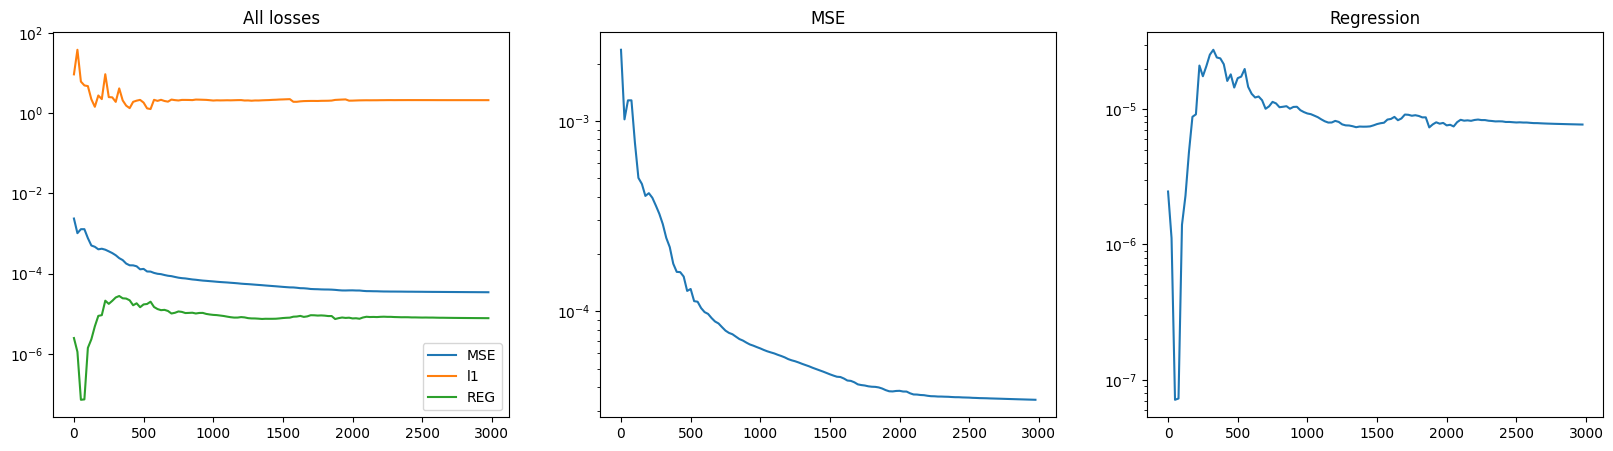

In [6]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.semilogy(df.index, df['loss_l1_output_0'], label='l1')
plt.semilogy(df.index, df['loss_reg_output_0'], label='REG')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['loss_reg_output_0'], label='PI')
plt.title('Regression')

In [7]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']

Text(0.5, 1.0, 'Coefficients')

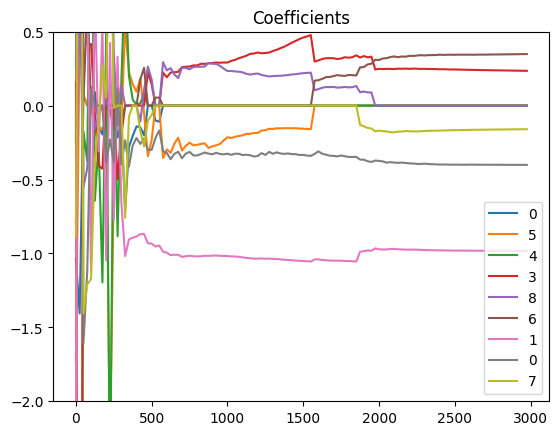

In [8]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-2, 0.5])
plt.title('Coefficients')

In [9]:
unscaled_coeff_keys = [key for key in df.keys() if key.__contains__('unscaled_coeffs_output')]
print(unscaled_coeff_keys)

['unscaled_coeffs_output_0_coeff_5', 'unscaled_coeffs_output_0_coeff_2', 'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4', 'unscaled_coeffs_output_0_coeff_8', 'unscaled_coeffs_output_0_coeff_1', 'unscaled_coeffs_output_0_coeff_6', 'unscaled_coeffs_output_0_coeff_7', 'unscaled_coeffs_output_0_coeff_0']


Text(0.5, 1.0, 'Coefficients')

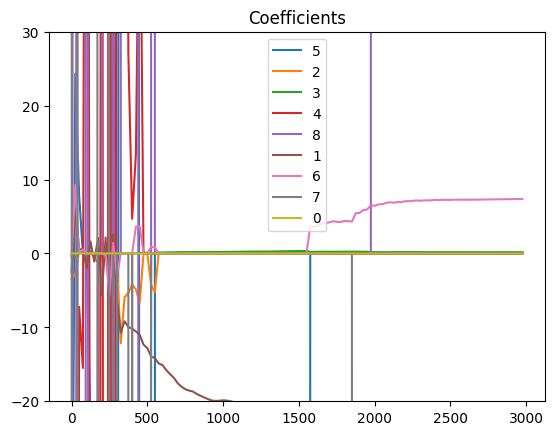

In [10]:
for key in unscaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-20, 30])
plt.title('Coefficients')

In [11]:
C_0 = df['unscaled_coeffs_output_0_coeff_0'].iloc[-1]
print('C_0 = ', C_0)
C_1 = df['unscaled_coeffs_output_0_coeff_1'].iloc[-1]
print('C_1 = ', C_1)
C_2 = df['unscaled_coeffs_output_0_coeff_2'].iloc[-1]
print('C_2 = ', C_2)
C_3 = df['unscaled_coeffs_output_0_coeff_3'].iloc[-1]
print('C_3 = ', C_3)
C_4 = df['unscaled_coeffs_output_0_coeff_4'].iloc[-1]
print('C_4 = ', C_4)
C_5 = df['unscaled_coeffs_output_0_coeff_5'].iloc[-1]
print('C_5 = ', C_5)
C_6 = df['unscaled_coeffs_output_0_coeff_6'].iloc[-1]
print('C_6 = ', C_6)
C_7 = df['unscaled_coeffs_output_0_coeff_7'].iloc[-1]
print('C_7 = ', C_7)
C_7 = 0.0
print('C_7_new = ', C_7)
C_8 = df['unscaled_coeffs_output_0_coeff_8'].iloc[-1]
print('C_8 = ', C_8)

C_0 =  -0.006739623844623566
C_1 =  -21.58724594116211
C_2 =  0.0
C_3 =  0.16793648898601532
C_4 =  0.0
C_5 =  0.0
C_6 =  7.368802070617676
C_7 =  -5805.5244140625
C_7_new =  0.0
C_8 =  0.0


In [12]:
# eqilibrate the matrix with data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#signal_matrix_equilibrated = pd.read_csv('dataset/signal_matrix_equilibrated.csv')
signal_matrix_equilibrated = pd.read_csv('dataset/signal_matrix_space_data.csv')
plot_time_label_df = pd.read_csv('dataset/plot_time_label_df.csv')

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

signal_matrix_equilibrated_dx = signal_space_derivative(signal_matrix_equilibrated,160,20,1,15)
signal_matrix_equilibrated_dxdx = signal_space_derivative(signal_matrix_equilibrated_dx,160,20,1,15)
signal_matrix_equilibrated_dxdxdx = signal_space_derivative(signal_matrix_equilibrated_dxdx,160,20,1,15)
min_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].min()
max_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].max()
nb_nx_points = 140
signal_matrix_space = signal_x_common_base(signal_matrix_equilibrated,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dx = signal_x_common_base(signal_matrix_equilibrated_dx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdx = signal_x_common_base(signal_matrix_equilibrated_dxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdxdx = signal_x_common_base(signal_matrix_equilibrated_dxdxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)

signal_matrix_time = signal_matrix_space.copy()
signal_matrix_time_temporal_nx = signal_matrix_time['nx']
signal_matrix_time.drop(['nx'], axis=1, inplace=True)
signal_matrix_time = signal_matrix_time.T
signal_matrix_time.reset_index(drop=True, inplace=True)
signal_matrix_time['nt'] = plot_time_label_df.loc[:,'frame_in_hours'].values

signal_matrix_time_dt = signal_time_derivative(signal_matrix_time,160,20,1,9)
signal_matrix_time_dtdt = signal_time_derivative(signal_matrix_time_dt,160,20,1,9)
min_nt = signal_matrix_time_dtdt['nt'].min()
max_nt = signal_matrix_time_dtdt['nt'].max()
nb_nt_points = 160

signal_matrix_time_dt = signal_t_common_base(signal_matrix_time_dt, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_time_dt.drop(['nt'], axis=1, inplace=True)
signal_matrix_time_dt_transposed = signal_matrix_time_dt.T
signal_matrix_time_dt_transposed['nx'] = signal_matrix_time_temporal_nx
signal_matrix_time_dt_normal = signal_x_common_base(signal_matrix_time_dt_transposed,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_time_dt_normal.drop(['nx'], axis=1, inplace=True)

In [14]:
print('signal u_t shape')
print(signal_matrix_time_dt_normal.shape)
signal_matrix_space_dx_temporal = signal_matrix_space_dx.copy()
signal_matrix_space_dx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dx_temporal = signal_matrix_space_dx_temporal.T
signal_matrix_space_dx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dx_temporal = signal_t_common_base(signal_matrix_space_dx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dx_normal = signal_matrix_space_dx_temporal.T
print('signal u_x shape')
print(signal_matrix_space_dx_normal.shape)

signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx.copy()
signal_matrix_space_dxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx_temporal.T
signal_matrix_space_dxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdx_temporal = signal_t_common_base(signal_matrix_space_dxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdx_normal = signal_matrix_space_dxdx_temporal.T
print('signal u_xx shape')
print(signal_matrix_space_dxdx_normal.shape)

signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx.copy()
signal_matrix_space_dxdxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx_temporal.T
signal_matrix_space_dxdxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdxdx_temporal = signal_t_common_base(signal_matrix_space_dxdxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_normal = signal_matrix_space_dxdxdx_temporal.T
print('signal u_xxx shape')
print(signal_matrix_space_dxdxdx_normal.shape)


signal_matrix_space_temporal = signal_matrix_space.copy()
signal_matrix_space_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_temporal = signal_matrix_space_temporal.T
signal_matrix_space_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_temporal = signal_t_common_base(signal_matrix_space_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_normal = signal_matrix_space_temporal.T
print('signal u shape')
print(signal_matrix_space_normal.shape)
signal_matrix_space_square_normal = signal_matrix_space_normal**2
print('signal u^2 shape')
print(signal_matrix_space_normal.shape)

signal u_t shape
(140, 160)
signal u_x shape
(140, 160)
signal u_xx shape
(140, 160)
signal u_xxx shape
(140, 160)
signal u shape
(140, 160)
signal u^2 shape
(140, 160)


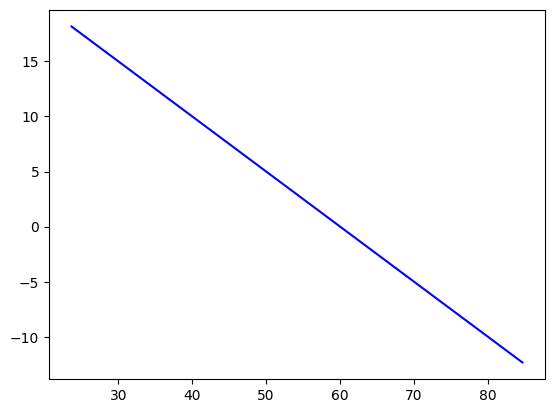

In [22]:
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
grad_space_coeff = -0.5
space_coeff_off = 30
space_gradient = grad_space_coeff*nx_linearized + space_coeff_off
plt.plot(nx_linearized,space_gradient,'b')
matrix_gradient = pd.DataFrame().reindex_like(signal_matrix_space_normal)
for column in matrix_gradient.columns:
    matrix_gradient[column] = space_gradient

In [23]:
signal_matrix_equation_normal = signal_matrix_space_dx_normal*matrix_gradient + \
                                signal_matrix_space_dxdx_normal*C_2 + \
                                signal_matrix_space_dxdxdx_normal*C_3 + \
                                signal_matrix_space_normal*C_4 + \
                                signal_matrix_space_normal * signal_matrix_space_dx_normal*C_5 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdx_normal*C_6 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdxdx_normal* C_7 + \
                                signal_matrix_space_square_normal * C_8  + C_0

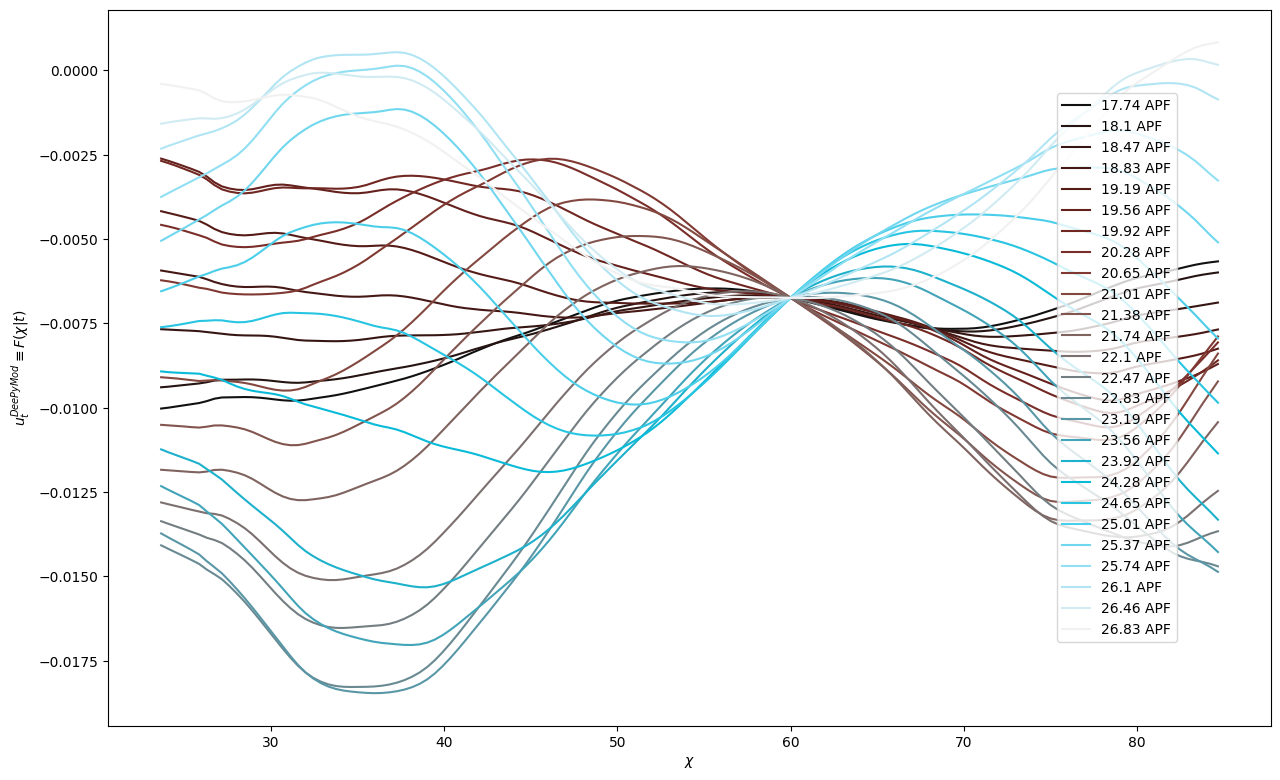

In [24]:
plot_factor = 2
ratio = 1
figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
signal_matrix_space_normal_to_plot = signal_matrix_equation_normal.copy()
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
signal_matrix_space_normal_to_plot['nx'] = nx_linearized
end_frame = 130
start_frame = 1
delta_t = 5
chi_threshold = 20
derivative_label = 'u^{DeePyMod}_t'
#angle = np.round(angle, decimals = 3)
#label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
#title = 'signal ' + quantity + ', '+ label
cmap = cc.cm.CET_CBTL2
colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
signal = signal_matrix_space_normal_to_plot.copy()
signal = signal[(signal['nx']>chi_threshold)]
for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
    plt.plot(signal['nx'], signal.loc[:,time_frame],c=color,label = str(np.round(nt_linearized[time_frame],decimals = 2))+' APF')
#plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
#xleft, xright = ax.get_xlim()
#ybottom, ytop = ax.get_ylim()
#ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
#plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
#ax.set_ylim([-0.1, 0.1])
#if FIGURES_DIR != '':
#    plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
plt.show()